# XGBoost Classification Model (Clean Version)

Ce notebook utilise l'utilitaire DataPreprocessor pour préparer les données et entraîner un modèle XGBoost pour la classification de signaux de trading crypto.

In [51]:
import sys
import os
# Ajoute le dossier racine du projet au sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root ajouté au sys.path :", project_root)

Project root ajouté au sys.path : /raid/home/automatants/lahrach_cha/ChakibProjects/ifcob


In [52]:
# Imports principaux
import pandas as pd
import numpy as np
from prediction_model.data_preprocess import DataPreprocessor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Chargement des données ETH et XBT
eth_path = "../../data/features/DATA_0/ETH_EUR.parquet"
xbt_path = "../../data/features/DATA_0/XBT_EUR.parquet"
df_eth = pd.read_parquet(eth_path)
df_xbt = pd.read_parquet(xbt_path)
print(f"ETH shape: {df_eth.shape}")
print(f"XBT shape: {df_xbt.shape}")

ETH shape: (1817685, 63)
XBT shape: (563395, 63)


In [54]:
df_eth.columns

Index(['bid-ask-imbalance-5-levels', 'spread', 'slope-bid-5-levels',
       'slope-ask-5-levels', 'vwap-bid-5-levels', 'vwap-ask-5-levels',
       'liquidity-ratio-5-levels', 'rate-inst-volatility-20-sample',
       'rate-momentum-20-sample', 'rate-mid-price-trend-20-sample',
       'rate-bid-volume-level-1', 'rate-ask-volume-level-1', 'V-bid-5-levels',
       'V-ask-5-levels', 'inst-return', 'return-all-signed-for-5-ms',
       'return-all-signed-for-10-ms', 'return-all-signed-for-20-ms',
       'return-vs-volatility-5-ms', 'return-vs-volatility-10-ms',
       'return-vs-volatility-20-ms', 'sharpe-ratio-quantile-calibrated-5-ms',
       'level-1-bid-price', 'level-1-bid-volume', 'level-2-bid-price',
       'level-2-bid-volume', 'level-3-bid-price', 'level-3-bid-volume',
       'level-4-bid-price', 'level-4-bid-volume', 'level-5-bid-price',
       'level-5-bid-volume', 'level-6-bid-price', 'level-6-bid-volume',
       'level-7-bid-price', 'level-7-bid-volume', 'level-8-bid-price',
    

In [55]:
# Initialisation du DataPreprocessor
preprocessor = DataPreprocessor()

# Définition des colonnes features (XBT)
feature_columns = [
    "bid-ask-imbalance-5-levels",
    "spread",
    "inst-return",
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

target_column = "sharpe-ratio-quantile-calibrated-5-ms"

# Préparation des données (split train/test inclus)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    features_df=df_xbt,
    target_df=df_eth,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Label mapping: {preprocessor.get_label_mapping()}")

=== PRÉPARATION DES DONNÉES ADABOOST ===
Étape 1: Extraction du target 'sharpe-ratio-quantile-calibrated-5-ms'...
Target shape: (1817685,)
Étape 2: Sélection des features...
Features sélectionnées: ['bid-ask-imbalance-5-levels', 'spread', 'inst-return', 'V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Features shape avant dropna: (563395, 7)
Features shape après dropna: (562683, 7)
Étape 3: Alignement temporel avec np.searchsorted...
Features après filtrage: (1817685, 7)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Données après dropna et filtrage NaN: (1817685, 7)
Target après dropna et filtrage NaN: (1817685,)
Distribution des classes:
sharpe-ratio-quantile-calibrated-5-ms
-1     181769
 0    1454147
 1     181769
Name: count, dtype: int64
Proportions des classes:
sharpe-ratio-quantile-calibrated-5-ms
-1    0.100000
 0    0.799999
 1    0.100000
Name: proportion, dtype: float64
Étape 5: Conversion en arrays numpy...

=== RÉSULTA

In [56]:
# Affichage des données avant l'entraînement
print("=== DONNÉES AVANT ENTRAÎNEMENT ===")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_train:\n{X_train[:5]}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_train:\n{y_train[:10]}")
print(f"\nX_test shape: {X_test.shape}")
print(f"X_test:\n{X_test[:5]}")
print(f"\ny_test shape: {y_test.shape}")
print(f"y_test:\n{y_test[:10]}")
print(f"\nDistribution des classes dans y_train:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Classe {u}: {c} échantillons ({c/len(y_train)*100:.2f}%)")

=== DONNÉES AVANT ENTRAÎNEMENT ===

X_train shape: (1454148, 7)
X_train:
[[ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]
 [ 0.04714768  0.1         0.          8.2115191   7.472074   -0.5845447
   1.17771853]]

y_train shape: (1454148,)
y_train:
[0 0 0 0 0 0 0 0 0 0]

X_test shape: (363537, 7)
X_test:
[[ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.          7.78442349  2.31406029 -0.21838483
  10.03320524]
 [ 0.54170144  0.1         0.        

In [57]:
# Vérification des NaN dans les données d'entraînement et de test
print("=== VÉRIFICATION DES NaN DANS LES DONNÉES ===")

# Vérification X_train
x_train_nan = np.isnan(X_train)
x_train_has_nan = np.any(x_train_nan)
print(f"\nX_train contient des NaN: {x_train_has_nan}")
if x_train_has_nan:
    nan_indices = np.where(x_train_nan)
    print(f"Nombre total de NaN dans X_train: {np.sum(x_train_nan)}")
    print(f"Lignes avec NaN: {np.unique(nan_indices[0])[:10]}...")  # Affiche les 10 premières
    print(f"Colonnes avec NaN: {np.unique(nan_indices[1])}")

# Vérification X_test
x_test_nan = np.isnan(X_test)
x_test_has_nan = np.any(x_test_nan)
print(f"\nX_test contient des NaN: {x_test_has_nan}")
if x_test_has_nan:
    nan_indices = np.where(x_test_nan)
    print(f"Nombre total de NaN dans X_test: {np.sum(x_test_nan)}")
    print(f"Lignes avec NaN: {np.unique(nan_indices[0])[:10]}...")  # Affiche les 10 premières
    print(f"Colonnes avec NaN: {np.unique(nan_indices[1])}")

# Vérification y_train
y_train_nan = np.isnan(y_train)
y_train_has_nan = np.any(y_train_nan)
print(f"\ny_train contient des NaN: {y_train_has_nan}")
if y_train_has_nan:
    nan_indices = np.where(y_train_nan)[0]
    print(f"Nombre de NaN dans y_train: {np.sum(y_train_nan)}")
    print(f"Indices avec NaN: {nan_indices[:10]}...")  # Affiche les 10 premiers

# Vérification y_test
y_test_nan = np.isnan(y_test)
y_test_has_nan = np.any(y_test_nan)
print(f"\ny_test contient des NaN: {y_test_has_nan}")
if y_test_has_nan:
    nan_indices = np.where(y_test_nan)[0]
    print(f"Nombre de NaN dans y_test: {np.sum(y_test_nan)}")
    print(f"Indices avec NaN: {nan_indices[:10]}...")  # Affiche les 10 premiers

=== VÉRIFICATION DES NaN DANS LES DONNÉES ===

X_train contient des NaN: False

X_test contient des NaN: False

y_train contient des NaN: False

y_test contient des NaN: False


In [58]:
# Calcul des poids pour équilibrer les classes
class_weights = compute_class_weight('balanced', classes=unique, y=y_train)
class_weight_dict = dict(zip(unique, class_weights))
print(f"Class weights: {class_weight_dict}")

# Création des sample weights pour XGBoost
sample_weights = np.array([class_weight_dict[label] for label in y_train])
print(f"Sample weights shape: {sample_weights.shape}")
print(f"Sample weights min/max: {sample_weights.min():.4f}/{sample_weights.max():.4f}")

Class weights: {np.int64(0): np.float64(3.3889588052688984), np.int64(1): np.float64(0.42076260813858407), np.int64(2): np.float64(3.0461143999095057)}
Sample weights shape: (1454148,)
Sample weights min/max: 0.4208/3.3890


In [66]:
# Initialisation du modèle XGBoost
xgb_classifier = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Modèle XGBoost initialisé")
print(f"Paramètres: n_estimators={xgb_classifier.n_estimators}, max_depth={xgb_classifier.max_depth}, learning_rate={xgb_classifier.learning_rate}")

Modèle XGBoost initialisé
Paramètres: n_estimators=150, max_depth=5, learning_rate=0.15


In [67]:
# Entraînement du modèle XGBoost
print("Entraînement du modèle XGBoost en cours...")
xgb_classifier.fit(X_train, y_train, sample_weight=sample_weights, verbose=False)
print("Modèle XGBoost entraîné!")

Entraînement du modèle XGBoost en cours...


/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:34:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modèle XGBoost entraîné!


In [68]:
# Prédictions et évaluation
y_pred = xgb_classifier.predict(X_test)
y_train_pred = xgb_classifier.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n=== RÉSULTATS DU MODÈLE XGBOOST ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Différence (overfitting): {train_acc - test_acc:.4f}")

print("\n=== CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test, y_pred))

print("\n=== CONFUSION MATRIX (TEST SET) ===")
print(confusion_matrix(y_test, y_pred))


=== RÉSULTATS DU MODÈLE XGBOOST ===
Train Accuracy: 0.5663
Test Accuracy: 0.4429
Différence (overfitting): 0.1234

=== CLASSIFICATION REPORT (TEST SET) ===
              precision    recall  f1-score   support

           0       0.12      0.25      0.16     38741
           1       0.83      0.47      0.60    302153
           2       0.08      0.37      0.12     22643

    accuracy                           0.44    363537
   macro avg       0.34      0.36      0.30    363537
weighted avg       0.71      0.44      0.53    363537


=== CONFUSION MATRIX (TEST SET) ===
[[  9543  18591  10607]
 [ 65422 143008  93723]
 [  4367   9816   8460]]



=== IMPORTANCE DES FEATURES ===
                      feature  importance
5          slope-bid-5-levels    0.238303
6          slope-ask-5-levels    0.185049
3              V-bid-5-levels    0.162366
4              V-ask-5-levels    0.148348
0  bid-ask-imbalance-5-levels    0.142113
2                 inst-return    0.073918
1                      spread    0.049902


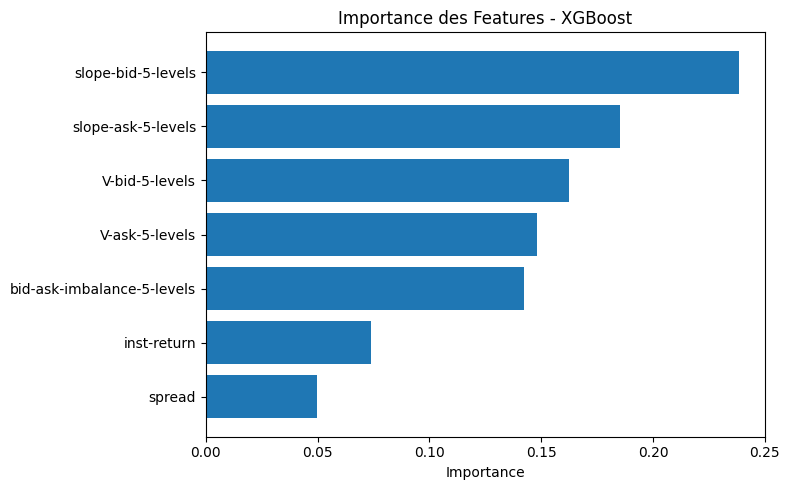

In [62]:
# Visualisation des importances des features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== IMPORTANCE DES FEATURES ===")
print(feature_importance)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

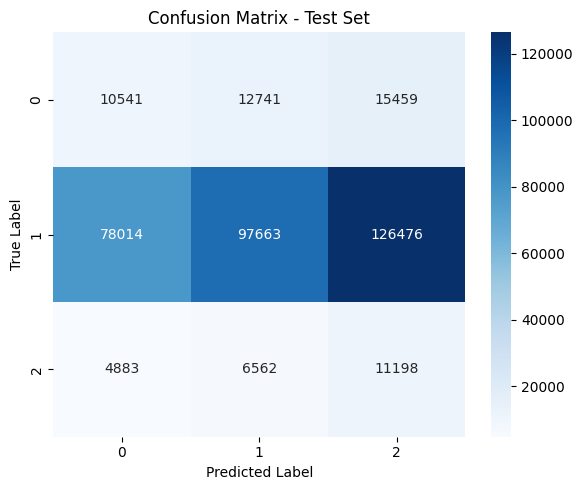

In [63]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [64]:
# Test avec différents paramètres XGBoost
print("\n=== COMPARAISON DE DIFFÉRENTS PARAMÈTRES XGBOOST ===")

params_to_test = [
    {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 2},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 150, 'learning_rate': 0.15, 'max_depth': 4},
    {'n_estimators': 200, 'learning_rate': 0.08, 'max_depth': 3},
]

results = []

for i, params in enumerate(params_to_test):
    print(f"\nTest {i+1}: n_est={params['n_estimators']}, lr={params['learning_rate']}, depth={params['max_depth']}")
    
    # Créer un nouveau modèle avec ces paramètres
    temp_classifier = xgb.XGBClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Entraîner
    temp_classifier.fit(X_train, y_train, sample_weight=sample_weights, verbose=False)
    
    # Prédire
    temp_pred = temp_classifier.predict(X_test)
    temp_accuracy = accuracy_score(y_test, temp_pred)
    
    results.append({
        'params': params,
        'accuracy': temp_accuracy
    })
    
    print(f"Accuracy: {temp_accuracy:.4f}")

# Meilleur modèle
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\n=== MEILLEUR PARAMÉTRAGE ===")
print(f"Paramètres: {best_result['params']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")


=== COMPARAISON DE DIFFÉRENTS PARAMÈTRES XGBOOST ===

Test 1: n_est=50, lr=0.05, depth=2


/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:30:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.2589

Test 2: n_est=100, lr=0.1, depth=3


/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:30:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.3284

Test 3: n_est=150, lr=0.15, depth=4


/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.4025

Test 4: n_est=200, lr=0.08, depth=3


/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:30:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.3350

=== MEILLEUR PARAMÉTRAGE ===
Paramètres: {'n_estimators': 150, 'learning_rate': 0.15, 'max_depth': 4}
Accuracy: 0.4025


In [65]:
# Statistiques finales et sauvegarde
print("\n=== STATISTIQUES FINALES ===")
print(f"Nombre total d'échantillons d'entraînement: {len(X_train)}")
print(f"Nombre total d'échantillons de test: {len(X_test)}")
print(f"Nombre de features: {X_train.shape[1]}")
print(f"Features utilisées: {list(feature_columns)}")
print(f"Classes dans le dataset: {sorted(np.unique(y_train))}")

print(f"\nPerformances du modèle XGBoost final:")
print(f"- Train Accuracy: {train_acc:.4f}")
print(f"- Test Accuracy: {test_acc:.4f}")
print(f"- Feature la plus importante: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})")

# Option pour sauvegarder le modèle
# import joblib
# os.makedirs("../../predictors/xgboost", exist_ok=True)
# joblib.dump(xgb_classifier, '../../predictors/xgboost/xgb_model_5ms.joblib')
# print("\nModèle sauvegardé dans '../../predictors/xgboost/xgb_model_5ms.joblib'")

print("\n=== ANALYSE TERMINÉE ===")


=== STATISTIQUES FINALES ===
Nombre total d'échantillons d'entraînement: 1454148
Nombre total d'échantillons de test: 363537
Nombre de features: 7
Features utilisées: ['bid-ask-imbalance-5-levels', 'spread', 'inst-return', 'V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Classes dans le dataset: [np.int64(0), np.int64(1), np.int64(2)]

Performances du modèle XGBoost final:
- Train Accuracy: 0.4006
- Test Accuracy: 0.3284
- Feature la plus importante: slope-bid-5-levels (0.2383)

=== ANALYSE TERMINÉE ===
